In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('pubmed_results.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Article ID,Details
0,38008732,\nPMID- 38008732\nOWN - NLM\nSTAT- In-Process\...
1,38008606,\nPMID- 38008606\nOWN - NLM\nSTAT- Publisher\n...
2,38008436,\nPMID- 38008436\nOWN - NLM\nSTAT- Publisher\n...
3,38008367,\nPMID- 38008367\nOWN - NLM\nSTAT- Publisher\n...
4,38008349,\nPMID- 38008349\nOWN - NLM\nSTAT- Publisher\n...


In [ ]:
df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(9999, 2)

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    if isinstance(text, str):
        # Tokenization
        tokens = word_tokenize(text)

        # Lowercasing
        tokens = [token.lower() for token in tokens]

        # Removing punctuation and special characters
        tokens = [token for token in tokens if token.isalnum()]

        # Removing stop words
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        # Stemming
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

        # Join the tokens back into a single string
        preprocessed_text = ' '.join(tokens)

        return preprocessed_text
    else:
        return ""

def extract_title_abstract(details):
    lines = str(details).split('\n')
    title = ""
    abstract = ""
    abstract_started = False
    for line in lines:
        if line.startswith("TI  - "):  # Assuming TI - denotes the title
          title = line[6:]
        elif line.startswith("AB  - "):  # Assuming AB - denotes the abstract
          abstract_started = True
          abstract += line[6:] + ' '
        elif abstract_started and line.startswith("CI  - "):  # Assuming CI - denotes the end of abstract
          break
        elif abstract_started:
          abstract += line + ' '

    return title, abstract.strip()

"""
def extract_title_abstract(details):
    # Extracting Title and Abstract
    lines = str(details).split('\n')
    title = ""
    abstract = ""

    for line in lines:
        if line.startswith("TI  - "):  # Assuming TI - denotes the title
            title = line[6:]
        elif line.startswith("AB  - "):  # Assuming AB - denotes the abstract
            abstract = line[6:]

    return title, abstract
"""
def extract_date(details):
    # Check if details is a string
    date_match = re.search(r'DP\s*-\s*(\d{4}\s[a-zA-Z]{3}\s\d{1,2})', str(details))
    if date_match:
      date_str = date_match.group(1)
      return pd.to_datetime(date_str, format='%Y %b %d', errors='coerce').strftime('%Y-%m-%d')

    return None

def add_healthcare_columns(df):
    df['contains_drug'] = df['Details'].apply(lambda x: 'drug' in str(x).lower())
    df['contains_disease'] = df['Details'].apply(lambda x: 'disease' in str(x).lower())
    df['contains_treatment'] = df['Details'].apply(lambda x: 'treatment' in str(x).lower())
    df['contains_symptom'] = df['Details'].apply(lambda x: 'symptom' in str(x).lower())
    df['contains_prevention'] = df['Details'].apply(lambda x: 'prevention' in str(x).lower())
    df['publication_year'] = df['Details'].apply(lambda x: re.findall(r'\b\d{4}\b', str(x)))
    df['contains_healthcare_provider'] = df['Details'].apply(lambda x: any(word in str(x).lower() for word in ['doctor', 'physician', 'healthcare provider']))
    df['contains_vaccine'] = df['Details'].apply(lambda x: 'vaccine' in str(x).lower())
    df['contains_diagnosis'] = df['Details'].apply(lambda x: 'diagnosis' in str(x).lower())


    return df

def preprocess_and_enhance_csv(input_file, output_file):
    # Read the CSV file
    df = pd.read_csv(input_file)

    # Preprocess the 'Details' column
    #df['Preprocessed_Details'] = df['Details'].apply(preprocess_text)

    # Extract Title and Abstract
    df[['Title', 'Abstract']] = df['Details'].apply(extract_title_abstract).apply(pd.Series)
    df['Title_p'] = df['Title'].apply(preprocess_text)
    df['Abstract_p'] = df['Abstract'].apply(preprocess_text)
    df['Date'] = df['Details'].apply(extract_date)

    # Add healthcare-related columns
    df = add_healthcare_columns(df)

    # Save the preprocessed and enhanced data to a new CSV file
    df.to_csv(output_file, index=False)
    print(f"Preprocessed and enhanced data saved to {output_file}")

if __name__ == "__main__":
    input_file = "pubmed_results.csv"  # Replace with your CSV file name
    output_file = "final_healthcare_dataset1.csv"  # Adjust the output file name

    preprocess_and_enhance_csv(input_file, output_file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Preprocessed and enhanced data saved to final_healthcare_dataset1.csv


In [ ]:
df1 = pd.read_csv('final_healthcare_dataset1.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df1.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Article ID,Details,Title,Abstract,Title_p,Abstract_p,Date,contains_drug,contains_disease,contains_treatment,contains_symptom,contains_prevention,publication_year,contains_healthcare_provider,contains_vaccine,contains_diagnosis
0,38008732,\nPMID- 38008732\nOWN - NLM\nSTAT- In-Process\...,The Nottingham Ischaemic Cardiovascular Magnet...,INTRODUCTION: Research utilising artificial in...,nottingham ischaem cardiovascular magnet reson...,introduct research utilis artifici intellig ai...,2023-11-27,False,True,False,False,False,"['1532', '1097', '6647', '2023', '1186', '2023...",False,False,False
1,38008606,\nPMID- 38008606\nOWN - NLM\nSTAT- Publisher\n...,Prognostic factors for critically ill surgical...,BACKGROUND: Unplanned readmission to the surgi...,prognost factor critic ill surgic patient unpl...,background unplan readmiss surgic intens care ...,2023-11-25,False,True,False,False,False,"['1532', '7361', '0039', '6060', '2023', '6060...",False,False,False
2,38008436,\nPMID- 38008436\nOWN - NLM\nSTAT- Publisher\n...,Prevalence and Impact of Polyvascular Disease ...,BACKGROUND: This post hoc subanalysis aimed to...,preval impact polyvascular diseas patient acut...,background post hoc subanalysi aim investig im...,2023-11-23,False,True,False,False,False,"['1347', '4820', '1346', '9843', '2023', '1253...",False,False,False
3,38008367,\nPMID- 38008367\nOWN - NLM\nSTAT- Publisher\n...,Loss of sodium current caused by a Brugada syn...,BACKGROUND: Brugada syndrome (BrS) is an inher...,loss sodium current caus brugada variant,background brugada syndrom br inherit cardiac ...,2023-11-24,True,True,False,False,False,"['1556', '3871', '1547', '5271', '2023', '5271...",False,False,False
4,38008349,\nPMID- 38008349\nOWN - NLM\nSTAT- Publisher\n...,Predictors of Transthoracic Impedance in Patie...,Successful synchronized direct current cardiov...,predictor transthorac imped patient undergo el...,success synchron direct current cardiovers dcc...,2023-11-24,False,True,False,False,False,"['1879', '1913', '0002', '9149', '2023', '9149...",True,False,False


In [ ]:
df1["Abstract"][1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'BACKGROUND: Unplanned readmission to the surgical intensive care unit has been        demonstrated to worsen patient outcomes. Our objective was to identify risk        factors and outcomes associated with unplanned surgical intensive care unit        readmission and to develop a predictive scoring model to identify patients at        high risk of readmission. METHODS: We retrospectively analyzed patients admitted        to the surgical intensive care unit (2020-2021) and categorized them as either        with or without unplanned readmission. RESULTS: Of 1,112 patients in the        derivation cohort, 76 (6.8%) experienced unplanned surgical intensive care unit        readmission, with sepsis being the leading cause of readmission (35.5%). Patients        who were readmitted had significantly higher in-hospital mortality rates than        those who were not. Multivariate analysis identified congestive heart failure,        high Sequential Organ Failure Assessment-Hepatic score, use o

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Article ID                    9999 non-null   int64 
 1   Details                       9996 non-null   object
 2   Title                         9996 non-null   object
 3   Abstract                      8910 non-null   object
 4   Title_p                       9996 non-null   object
 5   Abstract_p                    8910 non-null   object
 6   Date                          6259 non-null   object
 7   contains_drug                 9999 non-null   bool  
 8   contains_disease              9999 non-null   bool  
 9   contains_treatment            9999 non-null   bool  
 10  contains_symptom              9999 non-null   bool  
 11  contains_prevention           9999 non-null   bool  
 12  publication_year              9999 non-null   object
 13  contains_healthcar

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df2 = df1.drop(["Details","publication_year"],axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df2.to_csv('final_data.csv',index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


What percentage of articles contain information about drugs?

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


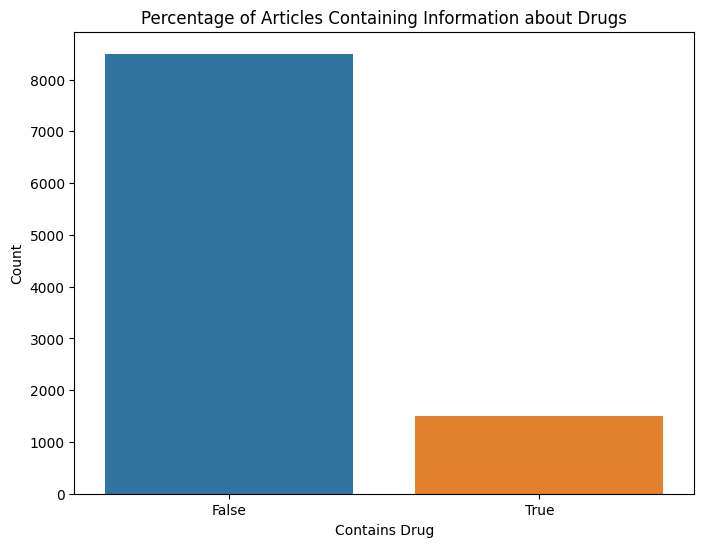

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.countplot(x='contains_drug', data=df1)
plt.title('Percentage of Articles Containing Information about Drugs')
plt.xlabel('Contains Drug')
plt.ylabel('Count')
plt.show()

How many articles mention diseases?

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


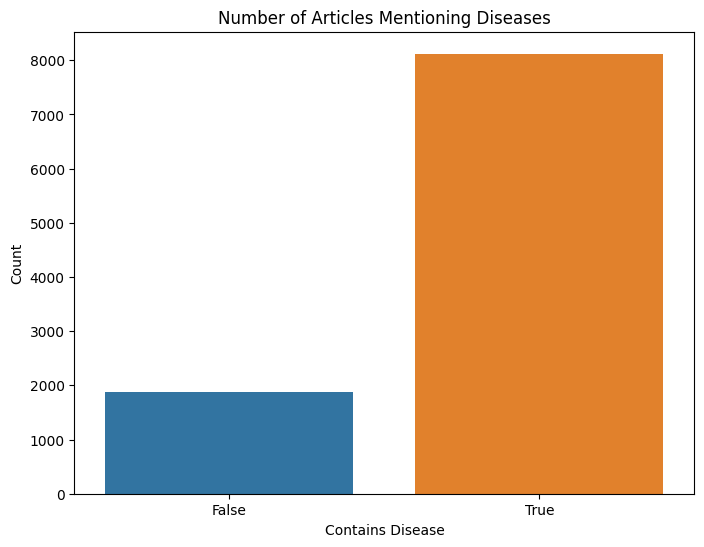

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='contains_disease', data=df1)
plt.title('Number of Articles Mentioning Diseases')
plt.xlabel('Contains Disease')
plt.ylabel('Count')
plt.show()


Number of articles mentioning treatments, symptoms, and prevention

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


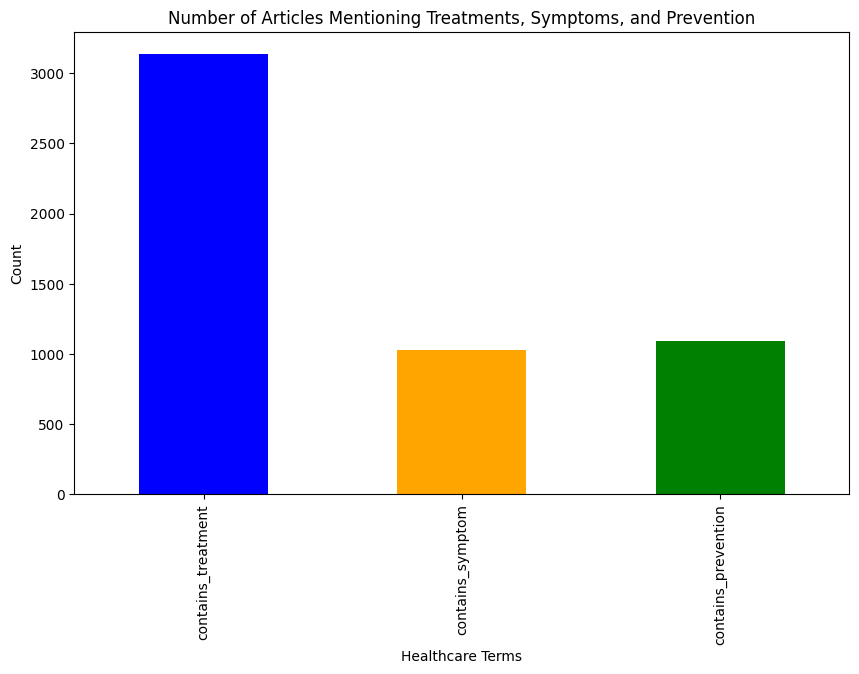

In [ ]:
plt.figure(figsize=(10, 6))
df1[['contains_treatment', 'contains_symptom', 'contains_prevention']].sum().plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Number of Articles Mentioning Treatments, Symptoms, and Prevention')
plt.xlabel('Healthcare Terms')
plt.ylabel('Count')
plt.show()

Distribution of articles containing information about vaccines

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


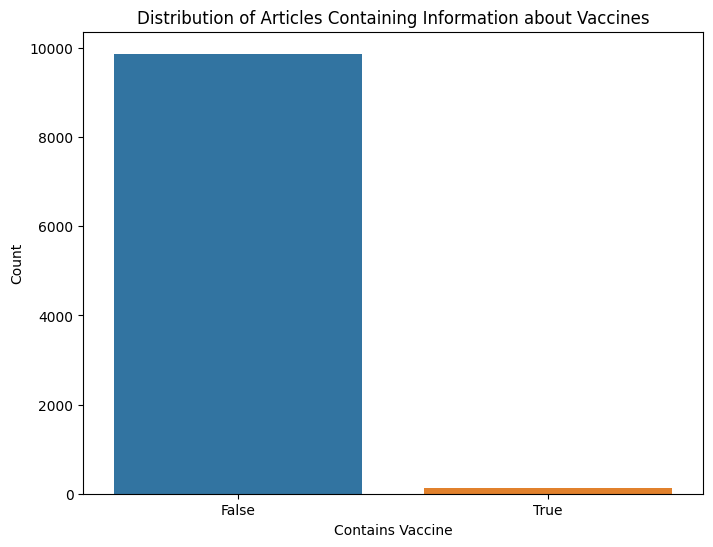

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='contains_vaccine', data=df1)
plt.title('Distribution of Articles Containing Information about Vaccines')
plt.xlabel('Contains Vaccine')
plt.ylabel('Count')
plt.show()

Pie chart of articles mentioning diagnosis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


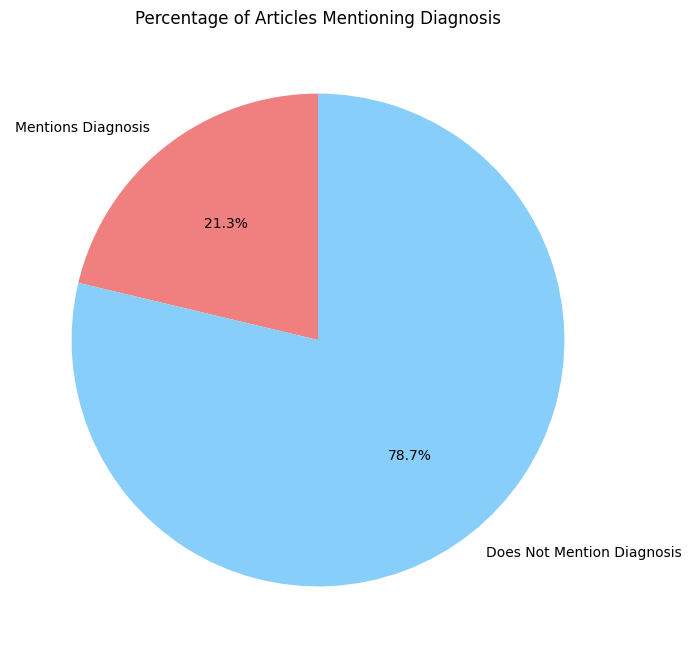

In [ ]:
plt.figure(figsize=(8, 8))
diagnosis_count = df1['contains_diagnosis'].sum()
diagnosis_percentage = (diagnosis_count / len(df)) * 100
labels = ['Mentions Diagnosis', 'Does Not Mention Diagnosis']
sizes = [diagnosis_count, len(df) - diagnosis_count]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
plt.title('Percentage of Articles Mentioning Diagnosis')
plt.show()

What are the most common terms in the preprocessed details?

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 10 most common terms in  Abstract:
[('ad', 27972), ('patient', 24266), ('au', 22762), ('fau', 22735), ('univers', 17553), ('diseas', 15018), ('heart', 14871), ('depart', 14485), ('mh', 13312), ('studi', 12968)]


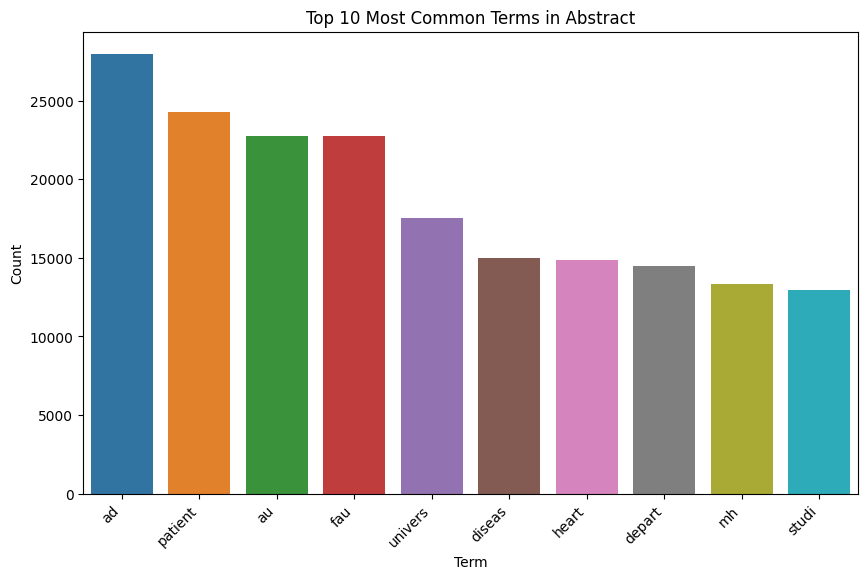

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=10):
    vec = CountVectorizer().fit(corpus.fillna(''))
    bag_of_words = vec.transform(corpus.fillna(''))
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_words = get_top_n_words(df1['Abstract_p'])
print("Top 10 most common terms in  Abstract:")
print(top_words)

top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Word', y='Count', data=top_words_df)
plt.title('Top 10 Most Common Terms in Abstract')
plt.xlabel('Term')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2023-12-05 09:27:48.178519: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 09:27:48.178601: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 09:27:48.178668: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 09:27:49.947864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


NER MODEL

In [ ]:
import pandas as pd
import spacy
from spacy import displacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Load your preprocessed healthcare dataset
input_file = "final_data.csv"
df = pd.read_csv(input_file)

# Apply NER to each article
def apply_ner(text):
    doc = nlp(str(text))
    return [(ent.text, ent.label_) for ent in doc.ents]

df['NER'] = df['Abstract_p'].apply(apply_ner)

# Display NER results for a sample article
sample_article_index = 0
sample_article_text = df.loc[sample_article_index, 'Abstract']
sample_article_ner = df.loc[sample_article_index, 'NER']
print(f"Sample Article:\n{sample_article_text}\n")
print("Named Entities:")
for ent, label in sample_article_ner:
    print(f"{ent} - {label}")

# Visualize NER for a sample article
sample_article_doc = nlp(sample_article_text)
displacy.render(sample_article_doc, style='ent', jupyter=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sample Article:
INTRODUCTION: Research utilising artificial intelligence (AI) and cardiovascular        magnetic resonance (CMR) is rapidly evolving with various objectives, however AI        model development, generalisation and performance may be hindered by availability        of robust training datasets including contrast enhanced images. METHODS: NotIs        CMR is a large UK, prospective, multicentre, observational cohort study to guide        the development of a biventricular AI scar model. Patients with ischaemic heart        disease undergoing clinically indicated contrast-enhanced cardiac magnetic        resonance imaging will be recruited at Nottingham University Hospitals NHS Trust        and Mid-Yorkshire Hospital NHS Trust. Baseline assessment will include cardiac        magnetic resonance imaging, demographic data, medical history,        electrocardiographic and serum biomarkers. Participants will undergo monitoring        for a minimum of 5 years to document any majo

TOPIC MODELLING

In [ ]:
!pip install gensim
!pip install pyldavis


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Load the preprocessed data
input_file = "final_data.csv"
df = pd.read_csv(input_file)

# Tokenize the preprocessed text
tokenized_text = [str(text).split() for text in df['Abstract_p']]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(tokenized_text)

# Convert the dictionary to a bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# Build the LDA model
num_topics = 5  # You can adjust the number of topics based on your dataset
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Visualize the topics
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!pip install "pandas<2.0.0"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 84.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.3
    Uninstalling pandas-2.1.3:
      Successfully uninstalled pandas-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
